## load the data

In [132]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE, RFECV, chi2, SelectKBest
from sklearn.linear_model import LogisticRegression

In [133]:
data_path = '../data/heart_disease.csv'

df = pd.read_csv(data_path)

NUMERIC_COLS = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
CATEGORICAL_COLS = [f for f in df.columns if f not in NUMERIC_COLS]

df.head(2)

,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,slope,ca,target,cp_2,cp_3,cp_4,restecg_1,restecg_2,thal_6,thal_7
0,63.0,1.0,145.0,233.0,1.0,150.0,0.0,2.3,3.0,0.0,0,0,0,0,0,1,1,0
1,67.0,1.0,160.0,286.0,0.0,108.0,1.0,1.5,2.0,3.0,1,0,0,1,0,1,0,0


In [134]:
# split the data
X = df.drop("target", axis=1)
y = df["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [135]:
# scale the numeric data
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[NUMERIC_COLS] = scaler.fit_transform(X_train_scaled[NUMERIC_COLS])
X_test_scaled[NUMERIC_COLS] = scaler.transform(X_test_scaled[NUMERIC_COLS])

# Feature importance
### using Random Forest Classifier

In [136]:
# train model
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Feature importance (based on trained model)
importances = rf.feature_importances_

# Rank features
imp_results = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
    }).sort_values('Importance', ascending=False)

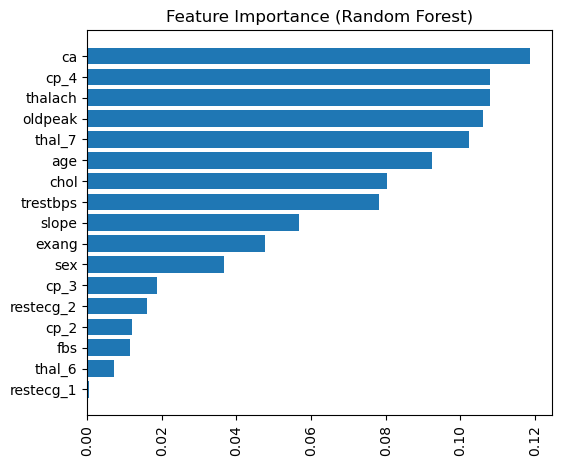

In [137]:
# plot ranked features
plt.figure(figsize=(6,5))
plt.barh(imp_results['Feature'], imp_results['Importance'])
plt.title("Feature Importance (Random Forest)")
plt.xticks(rotation=90)
plt.gca().invert_yaxis()  # This puts highest values at the TOP
plt.show()

## using Recursive Feature Elimination (RFE)

In [138]:
# RFE selected features
model = LogisticRegression(max_iter=2000, solver='liblinear', random_state=42)

rfe = RFE(estimator=model)
# rfe = RFECV(model, step=1, cv=5, scoring='accuracy')
rfe.fit(X_train_scaled, y_train)

rfe_results = pd.DataFrame({
    "Feature": list(X_train_scaled.columns),
    "Rank": rfe.ranking_,
}).sort_values("Rank", ascending=True)
print(rfe.n_features_)

8


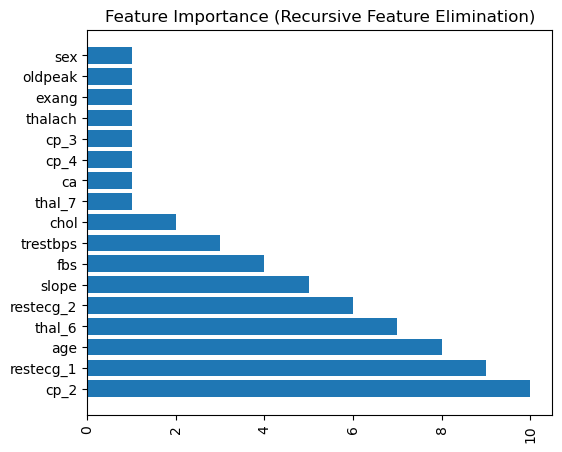

In [139]:
# plot ranked features
plt.figure(figsize=(6,5))
plt.barh(rfe_results['Feature'], rfe_results['Rank'])
plt.title("Feature Importance (Recursive Feature Elimination)")
plt.xticks(rotation=90)
plt.gca().invert_yaxis()  # This puts highest values at the TOP
plt.show()

## using Chi-Square Test

In [140]:
# scale the data (no negtive values)
scaler = MinMaxScaler()
X_chi = X_train.copy()
y_chi = y_train.copy()
X_chi[NUMERIC_COLS] = scaler.fit_transform(X_chi[NUMERIC_COLS])

In [141]:
# discretize continuous variables
kbins = KBinsDiscretizer(n_bins=5, encode="ordinal", strategy="quantile")
X_chi[NUMERIC_COLS] = kbins.fit_transform(X_chi[NUMERIC_COLS])

# Apply Chi-Square
chi2_selector = SelectKBest(score_func=chi2, k="all")
chi2_selector.fit(X_chi, y_chi)

chi2_results = pd.DataFrame({
    "Feature": X_chi.columns,
    "Chi2 Score": chi2_selector.scores_,
    "p-value": chi2_selector.pvalues_
}).sort_values("Chi2 Score", ascending=False)

# print(chi2_results)

c:\Users\WISH\Apps\miniconda3\envs\ds_env\Lib\site-packages\sklearn\preprocessing\_discretization.py:304: FutureWarning: The current default behavior, quantile_method='linear', will be changed to quantile_method='averaged_inverted_cdf' in scikit-learn version 1.9 to naturally support sample weight equivalence properties by default. Pass quantile_method='averaged_inverted_cdf' explicitly to silence this warning.
  warnings.warn(
c:\Users\WISH\Apps\miniconda3\envs\ds_env\Lib\site-packages\sklearn\preprocessing\_discretization.py:396: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 4 are removed. Consider decreasing the number of bins.
  warnings.warn(


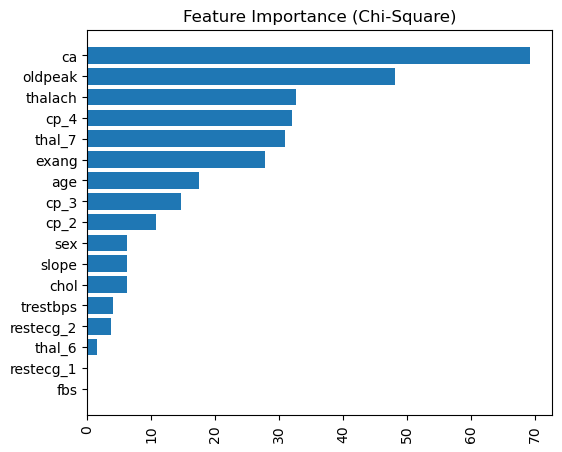

In [142]:
# plot ranked features
plt.figure(figsize=(6,5))
plt.barh(chi2_results['Feature'], chi2_results['Chi2 Score'])
plt.title("Feature Importance (Chi-Square)")
plt.xticks(rotation=90)
plt.gca().invert_yaxis()  # This puts highest values at the TOP
plt.show()

## Select top features

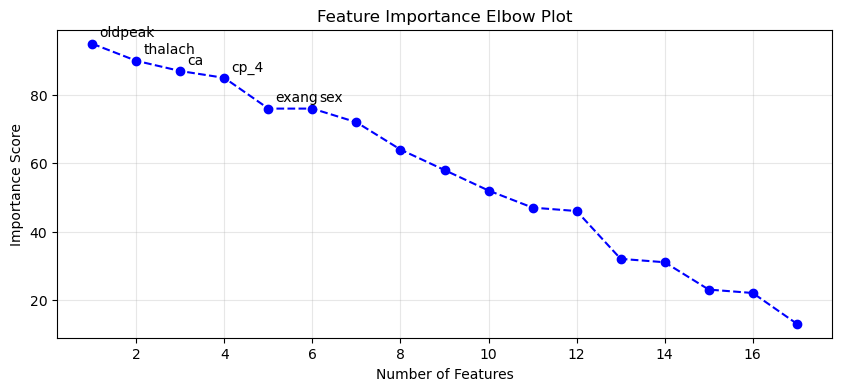

In [143]:
def ensemble_feature_selection():
    """Combine all three methods with voting"""
    methods_weights = {'chi2': 1, 'rf': 2, 'rfe': 3}  # Weight by reliability
    
    
    # Create voting system
    feature_votes = {}
    
    # Chi-square votes
    for i, feature in enumerate(chi2_results['Feature']):
        feature_votes[feature] = feature_votes.get(feature, 0) + methods_weights['chi2'] * (20 - i)
    
    # Random Forest votes
    for i, feature in enumerate(imp_results['Feature']):
        feature_votes[feature] = feature_votes.get(feature, 0) + methods_weights['rf'] * (20 - i)
    
    # RFE votes
    for i, feature in enumerate(rfe_results['Feature']):
        feature_votes[feature] = feature_votes.get(feature, 0) + methods_weights['rfe'] * (15 - i)
    
    # Sort by total votes
    final_ranking = pd.Series(feature_votes).sort_values(ascending=False)
    
    return final_ranking

# Combine all methods
final_ranking = ensemble_feature_selection()
# print("Final feature ranking:\n", final_ranking)


# plot final ranked features
plt.figure(figsize=(10, 4))
plt.plot(range(1, len(final_ranking) + 1), final_ranking, 'bo--')

plt.title("Feature Importance Elbow Plot")
plt.xlabel("Number of Features")
plt.ylabel("Importance Score")
plt.grid(True, alpha=0.3)

# annotation loop
for i, (name, score) in enumerate(final_ranking.items()):
    if i < 6: # Label top 6
        plt.annotate(name, (i + 1, score), xytext=(5, 5), textcoords='offset points')

plt.show()

In [144]:
n_features = 6 # based on best result from logistic regression
selected_features = final_ranking.index.to_list()[:n_features]

# Compare performance with vs without feature selection
from sklearn.metrics import accuracy_score, classification_report

# Train model on original features
model_original = LogisticRegression(max_iter=2000, random_state=42)
model_original.fit(X_train_scaled, y_train)
y_pred_original = model_original.predict(X_test_scaled)

# Train model on selected features
model_selected = LogisticRegression(max_iter=2000, random_state=42)
model_selected.fit(X_train_scaled[selected_features], y_train)
y_pred_selected = model_selected.predict(X_test_scaled[selected_features])

print("Original features accuracy:", accuracy_score(y_test, y_pred_original))
print("Selected features accuracy:", accuracy_score(y_test, y_pred_selected))
print("Original features report:\n", classification_report(y_test, y_pred_original))
print("Selected features report:\n", classification_report(y_test, y_pred_selected))

Original features accuracy: 0.8852459016393442
Selected features accuracy: 0.9016393442622951
Original features report:
               precision    recall  f1-score   support

           0       0.89      0.86      0.88        29
           1       0.88      0.91      0.89        32

    accuracy                           0.89        61
   macro avg       0.89      0.88      0.88        61
weighted avg       0.89      0.89      0.89        61

Selected features report:
               precision    recall  f1-score   support

           0       0.87      0.93      0.90        29
           1       0.93      0.88      0.90        32

    accuracy                           0.90        61
   macro avg       0.90      0.90      0.90        61
weighted avg       0.90      0.90      0.90        61



In [145]:
selected_features

['oldpeak', 'thalach', 'ca', 'cp_4', 'exang', 'sex']